<center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">به نام خدا</div></center>
<img src="https://github.com/Alireza-Akhavan/rnn-notebooks/blob/master/logo.png?raw=1" alt="class.vision" style="width: 200px;"/>
<h1><center><div style="direction:rtl;font-family:B Lotus, B Nazanin, Tahoma">تخمین قیمت ارزهای دیجیتال - قسمت 2 </div></center></h1>

# Balancing Recurrent Neural Network sequence data for our crypto predicting RNN

In [5]:
!mkdir crypto_data
!wget https://raw.githubusercontent.com/Alireza-Akhavan/datasets_and_models/main/crypto_data.zip
!unzip crypto_data.zip -d crypto_data

--2025-04-25 10:54:18--  https://raw.githubusercontent.com/Alireza-Akhavan/datasets_and_models/main/crypto_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5819754 (5.5M) [application/zip]
Saving to: ‘crypto_data.zip’

crypto_data.zip     100%[===================>]   5.55M  --.-KB/s    in 0.01s   

2025-04-25 10:54:18 (374 MB/s) - ‘crypto_data.zip’ saved [5819754/5819754]

Archive:  crypto_data.zip
  inflating: crypto_data/BCH-USD.csv  
  inflating: crypto_data/BTC-USD.csv  
  inflating: crypto_data/ETH-USD.csv  
  inflating: crypto_data/LTC-USD.csv  


In [6]:
import pandas as pd
from collections import deque
import random
import numpy as np
from sklearn import preprocessing

SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "LTC-USD"


def classify(current, future):
    if float(future) > float(current):  # if the future price is higher than the current, that's a buy, or a 1
        return 1
    else:  # otherwise... it's a 0!
        return 0

main_df = pd.DataFrame() # begin empty

ratios = ["BTC-USD", "LTC-USD", "BCH-USD", "ETH-USD"]  # the 4 ratios we want to consider
for ratio in ratios:  # begin iteration
    dataset = f'crypto_data/{ratio}.csv'  # get the full path to the file.
    df = pd.read_csv(dataset, names=['time', 'low', 'high', 'open', 'close', 'volume'])  # read in specific file

    # rename volume and close to include the ticker so we can still which close/volume is which:
    df.rename(columns={"close": f"{ratio}_close", "volume": f"{ratio}_volume"}, inplace=True)

    df.set_index("time", inplace=True)  # set time as index so we can join them on this shared time
    df = df[[f"{ratio}_close", f"{ratio}_volume"]]  # ignore the other columns besides price and volume

    if len(main_df)==0:  # if the dataframe is empty
        main_df = df  # then it's just the current df
    else:  # otherwise, join this data to the main one
        main_df = main_df.join(df)

main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)
#print(main_df.head())  # how did we do??

main_df['future'] = main_df[f'{RATIO_TO_PREDICT}_close'].shift(-FUTURE_PERIOD_PREDICT)
main_df['target'] = list(map(classify, main_df[f'{RATIO_TO_PREDICT}_close'], main_df['future']))

#print(main_df.head())

times = sorted(main_df.index.values)  # get the times
last_5pct = sorted(main_df.index.values)[-int(0.05*len(times))]  # get the last 5% of the times

validation_main_df = main_df[(main_df.index >= last_5pct)]  # make the validation data where the index is in the last 5%
main_df = main_df[(main_df.index < last_5pct)]  # now the main_df is all the data up to the last 5%

<ipython-input-6-a2e18d1ee7b8>:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values


Continuing along in our **preprocess_df** function, we can balance by doing:

In [34]:
def preprocess_df(df):
    df = df.drop("future", axis=1)  # don't need this anymore.

    for col in df.columns:  # go through all of the columns
        if col != "target":  # normalize all ... except for the target itself!
            df[col] = df[col].pct_change()  # pct change "normalizes" the different currencies (each crypto coin has vastly diff values, we're really more interested in the other coin's movements)
            df.dropna(inplace=True)  # remove the nas created by pct_change
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.

    df.dropna(inplace=True)  # cleanup again... jic.


    sequential_data = []  # this is a list that will CONTAIN the sequences
    prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

    for i in df.values:  # iterate over the values
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # append those bad boys!

    random.shuffle(sequential_data)  # shuffle for good measure.

    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells!

    lower = min(len(buys), len(sells))  # what's the shorter length?

    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys+sells  # add them together
    random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return np.array(X), np.array(y)  # return X and y...and make X a numpy array!

## We can now preprocess our data with:

In [9]:
main_df.head()

,BTC-USD_close,BTC-USD_volume,LTC-USD_close,LTC-USD_volume,BCH-USD_close,BCH-USD_volume,ETH-USD_close,ETH-USD_volume,future,target
time,,,,,,,,,,
1528968720,6487.379883,7.706374,96.660004,314.387024,870.859985,26.856577,486.01001,26.019083,96.389999,0
1528968780,6479.410156,3.088252,96.570000,77.129799,870.099976,1.124300,486.00000,8.449400,96.519997,0
1528968840,6479.410156,1.404100,96.500000,7.216067,870.789978,1.749862,485.75000,26.994646,96.440002,0
1528968900,6479.979980,0.753000,96.389999,524.539978,870.000000,1.680500,486.00000,77.355759,96.470001,1
1528968960,6480.000000,1.490900,96.519997,16.991997,869.989990,1.669014,486.00000,7.503300,96.400002,0


In [35]:
train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)

In [11]:
train_x.shape

(77922, 60, 8)

In [12]:
print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"Dont buys: {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")

train data: 77922 validation: 3860
Dont buys: 38961, buys: 38961
VALIDATION Dont buys: 1930, buys: 1930


***More about imbalance classification:***

  [class.vision free workshop](https://class.vision/product/%d8%a2%d9%85%d9%88%d8%b2%d8%b4-%d8%af%d8%a7%d8%af%d9%87-%d9%87%d8%a7%db%8c-%d9%86%d8%a7%d9%85%d8%aa%d9%88%d8%a7%d8%b2%d9%86-imbalanced-data/)

# Cryptocurrency-predicting RNN Model

In [14]:
import time

EPOCHS = 20  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.


Next let's build the model, first we need some imports:

In [17]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout, LSTM, LSTM, BatchNormalization

In [25]:
model = Sequential()
model.add(Input(shape=train_x.shape[1:]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

In [26]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

In [27]:
# Train model
history = model.fit(
    train_x, np.array(train_y),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y))

Epoch 1/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.5140 - loss: 0.7424 - val_accuracy: 0.5531 - val_loss: 0.6833
Epoch 2/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.5383 - loss: 0.6896 - val_accuracy: 0.5565 - val_loss: 0.6831
Epoch 3/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5560 - loss: 0.6841 - val_accuracy: 0.5666 - val_loss: 0.6797
Epoch 4/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.5639 - loss: 0.6814 - val_accuracy: 0.5606 - val_loss: 0.6782
Epoch 5/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.5697 - loss: 0.6788 - val_accuracy: 0.5676 - val_loss: 0.6782
Epoch 6/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.5714 - loss: 0.6783 - val_accuracy: 0.5687 - val_loss: 0.6790
Epoch 7/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.5787 - loss: 0.6752 - val_accuracy: 0.5718 - val_loss: 0.6800
Epoch 8/20
609/609 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.5841 - loss: 0.6711 - 

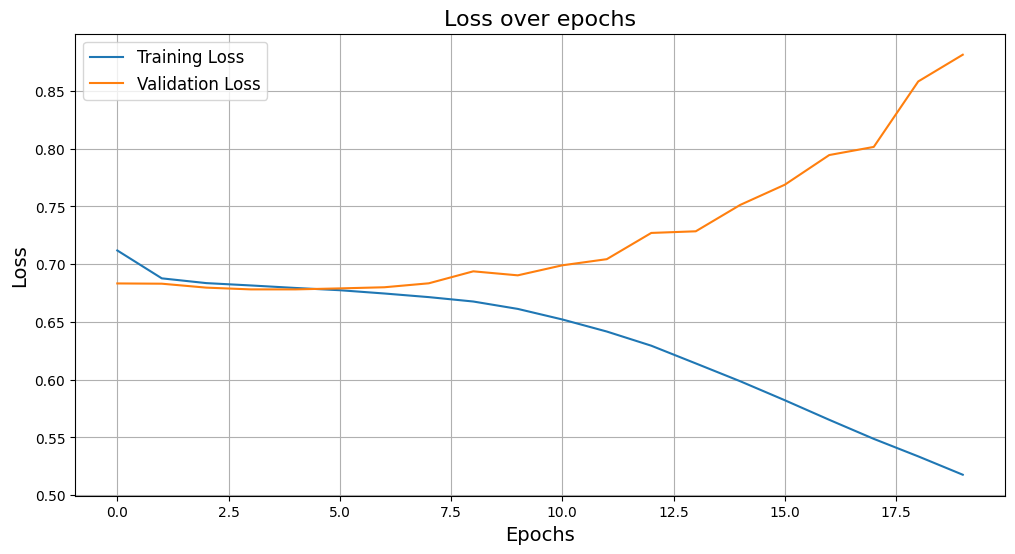

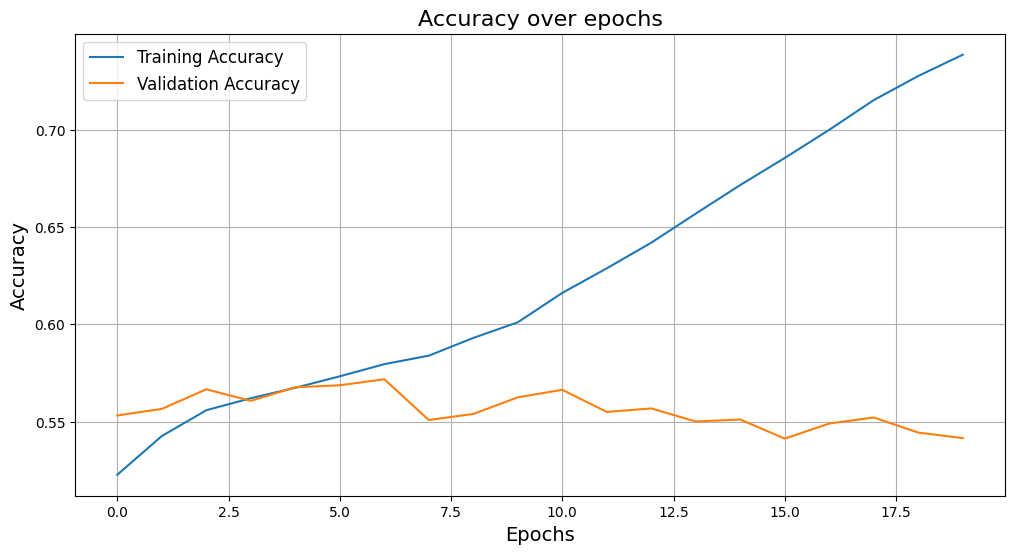

In [28]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [29]:
# Score model
score = model.evaluate(validation_x, np.array(validation_y), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8813402652740479
Test accuracy: 0.5414507985115051


In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  Bidirectional, Add

inputs = Input(shape=train_x.shape[1:])

x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)

residual = x
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = Add()([x, residual])

residual = x
x = Bidirectional(LSTM(64))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 60, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_15    │ (None, 60, 256)   │    140,288 │ input_layer_7[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 60, 256)   │          0 │ bidirectional_15… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ dropout_24[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_16    │ (None, 60, 256)   │    394,240 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 60, 256)   │          0 │ bidirectional_16… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ dropout_25[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 60, 256)   │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_17    │ (None, 128)       │    164,352 │ add_9[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 128)       │          0 │ bidirectional_17… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dropout_26[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │      4,128 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 32)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         33 │ dropout_27[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 705,601 (2.69 MB)

 Trainable params: 704,321 (2.69 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

BATCH_SIZE=64

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    callbacks=[EarlyStopping(patience=3, monitor='val_accuracy')])

Epoch 1/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.5115 - loss: 0.7633 - val_accuracy: 0.5598 - val_loss: 0.6830
Epoch 2/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - accuracy: 0.5415 - loss: 0.6883 - val_accuracy: 0.5645 - val_loss: 0.6804
Epoch 3/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.5555 - loss: 0.6840 - val_accuracy: 0.5702 - val_loss: 0.6793
Epoch 4/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.5564 - loss: 0.6838 - val_accuracy: 0.5650 - val_loss: 0.6816
Epoch 5/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.5632 - loss: 0.6829 - val_accuracy: 0.5733 - val_loss: 0.6793
Epoch 6/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.5621 - loss: 0.6808 - val_accuracy: 0.5744 - val_loss: 0.6747
Epoch 7/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 33s 27ms/step - accuracy: 0.5681 - loss: 0.6802 - val_accuracy: 0.5839 - val_loss: 0.6722
Epoch 8/20
1218/1218 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.5701 -

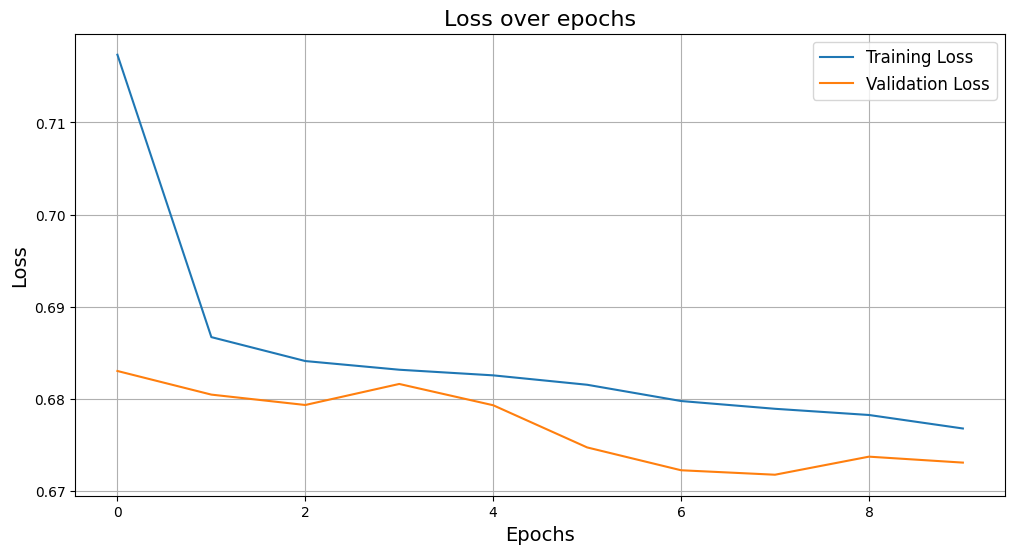

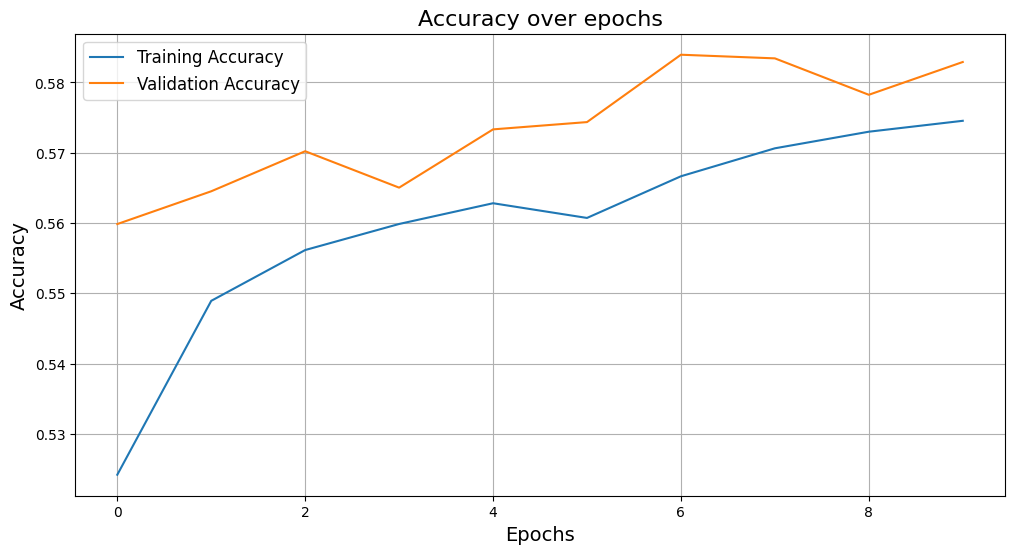

In [42]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## <div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma">منبع:</div>

https://becominghuman.ai/recurrent-neural-networks-rnn-deep-learning-w-python-tensorflow-keras-p-7-c21bc374d4dc

<div class="alert alert-block alert-info">
<div style="direction:rtl;text-align:right;font-family:B Lotus, B Nazanin, Tahoma"> دوره پیشرفته یادگیری عمیق<br>علیرضا اخوان پور<br>  آبان و آذر 1399<br>
</div>
<a href="http://class.vision">Class.Vision</a> - <a href="http://AkhavanPour.ir">AkhavanPour.ir</a> - <a href="https://github.com/Alireza-Akhavan/">GitHub</a>

</div>